# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.263721,False,-3.040264
1,-0.111994,True,5.857057
2,-0.507297,False,-2.346335
3,-1.736043,False,-5.415301
4,0.294744,True,7.500058
...,...,...,...
995,-1.695925,True,0.507453
996,-0.035035,True,4.021246
997,-0.929146,False,-1.979360
998,-1.293079,True,0.774261


<AxesSubplot: xlabel='v0'>

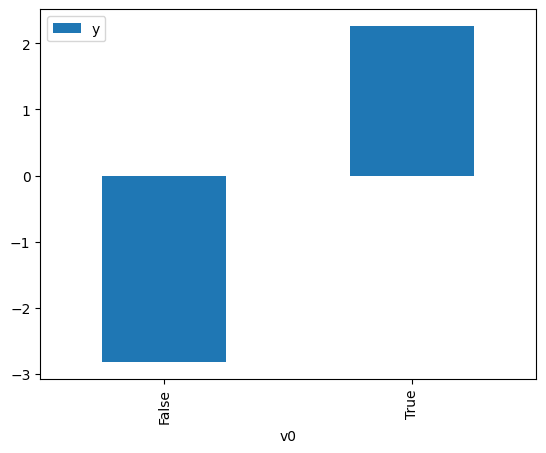

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

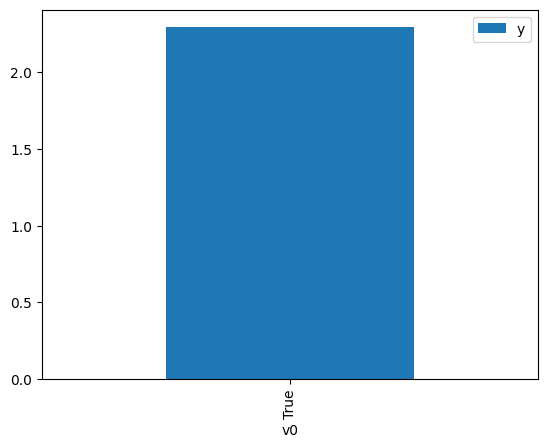

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.996805,False,-3.786357,0.513223,1.948469
1,0.404654,False,1.117376,0.485918,2.057960
2,-0.345309,False,-1.501684,0.494444,2.022474
3,-0.362435,False,-0.580447,0.494639,2.021677
4,-0.851442,False,-3.091548,0.500200,1.999200
...,...,...,...,...,...
995,0.032985,False,0.273542,0.490143,2.040222
996,-1.660649,False,-4.818721,0.509402,1.963085
997,-2.635309,False,-7.043708,0.520477,1.921315
998,-1.190256,False,-3.496641,0.504053,1.983917


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.323943,True,2.361578,0.494426,2.022546
1,-1.339604,True,0.070729,0.494248,2.023275
2,2.332462,True,10.671613,0.535949,1.865851
3,-0.095093,True,5.916268,0.508401,1.966951
4,0.348725,True,6.495579,0.513446,1.947623
...,...,...,...,...,...
995,-1.130484,True,2.736162,0.496626,2.013586
996,-0.913702,True,3.248578,0.499092,2.003639
997,-0.743403,True,4.239293,0.501029,1.995894
998,-2.787483,True,-3.273086,0.477796,2.092945


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              7196.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:48:31   Log-Likelihood:                         -1431.3
No. Observations:                1000   AIC:                                      2867.
Df Residuals:                     998   BIC:                                      2876.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8706      0.027    107.633      0.000       2.818       2.923
x2             4.9841      0.051     97.132      0.000       4.883       5.085
==============================================================================
Omnibus:                        0.221   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.895   Jarque-Bera (JB):                0.283
Skew:                          -0.030   Prob(JB):                        0.868
Kurtosis:                       2.942   Cond. No.                         2.34
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""